# Автоэнкодер

### Импортируем библиотеки 

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import logging
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from torchvision.utils import save_image
from IPython.display import Image, display 
import ipyplot

In [3]:
# Создаем параметр, который будет конвертировать наши данные в тензор
transform = transforms.ToTensor()

# Загружаем датасет MNIST
data_m = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Загражем данные с помощью utils, 
# разбиваем их на батчи по 64 штуки и перемешиваем, чтобы избежать переобучения
data_loader = torch.utils.data.DataLoader(dataset=data_m, batch_size=64, shuffle=True)

  ####  Делаем данные итирируемыми и инициализируем картинки, а также их лейблы (лейблами пользоваться не будем, так как они нужны для задачи классификации, а нам же нужно с помощью автоэнкодера восстанавливать изображения)

In [4]:
iter_data = iter(data_loader)
img, labels = next(iter_data)

#### Задаем параметры для логирования, которым мы будем пользоваться для контроля процесса обучения нашей моде

In [3]:
default_log_args = {
    "level": logging.DEBUG if os.environ.get("DEBUG", False) else logging.INFO,
    "format": "%(asctime)s [%(levelname)s] %(name)s - %(message)s",
    "datefmt": "%d-%b-%y %H:%M",
    "force": True,
}

#### Проверяем, что мы можем использовать нашу видеокарту для процесса обучения, чтобы увеличить его скорость

In [4]:
torch.cuda.is_available()

True

#### Создаем функцию, с помощью которой будем сохранять наши декодированные изображения 

In [5]:
def to_img(x):
    x = 0.6 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

#### Создаем функцию, которой мы будем "зашумлять" наши изображения, чтобы впоследствии проверить нашу модель на качество работы 

In [64]:
def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

#### Создаем наш автоенкодер, который будет использовать CNN слои и содежать следующие методы: нейронной сети (будем сохранять их в файл "model_weights.pth"). Продолжения работы с моделью (получать предобученные веса w и b будем из файла "model_weights.pth")

In [9]:
class Autoencoder(nn.Module):

    '''
    Autoencoder:
        get_arch - метод построения архитектуры автоэнкодера
        save_model - метод сохраняющий веса и архитектуру 
        load_model - для загрузки уже имеющихся весов

    '''

    def get_arch(self, f):
        encoder = nn.Sequential(
 
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # Поступаемая картинка 1 28 28 разбивается на 16 каналов, уменьшая наше изображение в 2 раза  
            nn.BatchNorm2d(16), # Нормадизуем наши данные, чтобы уменьшить значимость инициализируемых весов, а также для ускорения процесса оптимизации (поиска минимуму функции ошибки)
            nn.ReLU(),   # используем функцию активации и передаем значения в следующий слой, который работает аналогичным образом
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # финальная разбивка нашего изображения на 64 канала размерностью 1x1 
        )

        decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # восстанавливаем наше изображение из сжатой матрицы  в in_channels / out_channels раз (в нашем случае в 2 раза) p.s. есть крутая визуализация, которая объясняет, как работает conv2dTranspose https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
            nn.BatchNorm2d(32), # тут все аналогично с энкодером: нормализуем веса, чтобы оптимайзер быстрей нашел минимум функции потерь
            nn.ReLU(),
            # Оставшиеся 
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        if f == "encoder":
            return encoder
        elif f == "decoder":
            return decoder
        else:
            print("Incorrect input data, try again")

    def __init__(self):
        super().__init__()
        self.encoder = self.get_arch("encoder")
        self.decoder = self.get_arch("decoder")

    def save_model(self, model):
        torch.save(model.state_dict(), "model_weights.pth") # сохраняем веса нащей модели в файл "model_weights.pth"

    def load_model(self):
        # загружаем веса нащей модели в файл "model_weights.pth"
        model = TheModelClass(*args, **kwargs) 
        model.load_state_dict(torch.load("model_weights.pth"))
        return model

    def forward(self, x):
        # определяем, как наша модель будет работать на выходе и входе 
        #  (подаем данные, пропускаем через энкодер, потом выход из энкодера прогонаем через декодер и возвращаем аутпут)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
# Создаем объект класса Autoencoder и присваем его model
model = Autoencoder().cuda()
# Смотрим и надеемся, что все скомпилировалось без оказий  
print(model)
# Задаем параметр, с помощью которого будем оценивать качество работы нейронной модели (средняя квадратичная ошибка)
criterion = nn.MSELoss()
# Инициализуерм наш оптимайзер (тут без сюрпризов, используем Адам)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Инициализируем логи
logging.basicConfig(**default_log_args)
log = logging.getLogger("Run-Lambda")

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

In [11]:
# Обучаем нашу модель на видеокарте, высчитывая такие метрики, как loss, total_loss и SSIM (индекс структурного сходства)
num_epochs = 4
outputs = []
counter = 0
tmp = 0
for epoch in range(num_epochs):
    total_loss = 0
    for data in data_loader:
        img, _ = data
        img = Variable(img).cuda()
        recon = model(img)
        loss = criterion(recon, img)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.data
        ssim_none = ssim(np.squeeze(data[0].detach().numpy()), np.squeeze(recon.cpu().detach().numpy().data),
                     data_range=np.squeeze(data[0].detach().numpy()).max() - np.squeeze(recon.cpu().detach().numpy()).min())
    pic_autoencoder = to_img(recon.cpu().data)
    outputs.append(noise(data[0]))
#     Сохраняем наши изображения для дальнейших исследований 
    save_image(pic_autoencoder, './dc_img/image_{}.png'.format(epoch))
    save_image(to_img(data[0]), './basic_img/image_{}.png'.format(epoch))
    save_image(to_img(noise(data[0])),'./noise_img/image_{}.png'.format(epoch))
#     Выводим в логи информацию о процессе нашего обучения
    log.info('epoch [{}/{}], loss:{:.4f}, total_loss:{:.4f}, SSIM:{:.4f}'
              .format(epoch+1, num_epochs, loss.item(),total_loss, ssim_none))

25-Jan-24 14:02 [INFO] Run-Lambda - epoch [1/4], loss:0.0045, total_loss:13.0325, SSIM:0.9358
25-Jan-24 14:03 [INFO] Run-Lambda - epoch [2/4], loss:0.0032, total_loss:3.2849, SSIM:0.9611
25-Jan-24 14:03 [INFO] Run-Lambda - epoch [3/4], loss:0.0029, total_loss:2.8636, SSIM:0.9693
25-Jan-24 14:04 [INFO] Run-Lambda - epoch [4/4], loss:0.0025, total_loss:2.6711, SSIM:0.9676


#### Восстанавливаем с помощью нащей модели зашумленное изображение и смотрим на результат, сравнивая картинки "до" и "после" использования автоэнкодера 

In [12]:
model.save_model(model)

In [13]:
tmp = model(outputs[0].float().cuda()) 

In [14]:
res = to_img(tmp.cpu().data)

In [15]:
 save_image(res, 'image.png')

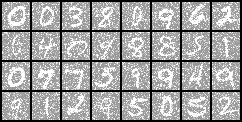

In [16]:
img_with_noise = Image(filename='./noise_img/image_0.png')

display(img_with_noise)

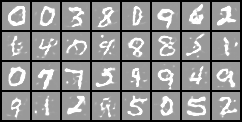

In [17]:
img_with_noise_after_autoencoder = Image(filename='image.png')

display(img_with_noise_after_autoencoder)

#### Промежуточный вывод: как мы могли заметить, наша модель смогла отлично очистить нашу картинку от шумов, оставив только цифры. 
#### С чем это связано:
 1) Использование CNN слоев, которые отлично подходят при работе с изображениями и позволяют добиться высокой точности за небольшое количество эпох
 2) Использование BatchNormalization - так мы ускорили сам процесс обучения и его качество, так как благодаря ней наши данные были нормализованы и равномерно распределены на плоскости
#### Что можно сделать еще?
  1) Варьировать количество слоев обработки
  2) Взять более интересный для наших целей датасет
  3) Улучшить визуализацию обучения
#### Давайте как раз этим и займемся!

#### Загрузим данные из датасете с цветочками

In [21]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

#### Функция, с помощью которой мы переведем наше изображение в удобный для нас вид

In [33]:
def to_img_flowers(x):
    x = 0.6 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 64, 64)
    return x

#### Загружаем датасет

In [22]:
train_dataset = datasets.Flowers102(root='flowers',
                                    split='train',
                                    transform=transform,
                                    download=True)

#### Передаем датасет в лоадер, которые преобразует наши данные для дальнейшей работы 

In [23]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)

#### Создаем максимально простую CNN, у которой энкодер и декодер состоят всего из двух слоев, плюс нормализация и функция активации

In [70]:
def get_arch(f):
        encoder = nn.Sequential(
 
            nn.Conv2d(3, 16, 3, stride=2, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.Conv2d(16, 8, 3, stride=2, padding=1)
        )

        decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        if f == "encoder":
            return encoder
        elif f == "decoder":
            return decoder
        else:
            print("Incorrect input data, try again")

#### Наш автоенкодер, тут все без изменений, только метод создания архитектуры вынесли в статическую функцию

In [58]:
class Autoencoder_flowers(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = get_arch("encoder")
        self.decoder = get_arch("decoder")

    def save_model(self, model):
        torch.save(model.state_dict(), "model_weights_flowers.pth") # сохраняем веса нащей модели в файл "model_weights.pth"

    def load_model(self):
        # загружаем веса нащей модели в файл "model_weights.pth"
        model = TheModelClass(*args, **kwargs) 
        model.load_state_dict(torch.load("model_weights_flowers.pth"))
        return model

    def forward(self, x):
        # определяем, как наша модель будет работать на выходе и входе 
        #  (подаем данные, пропускаем через энкодер, потом выход из энкодера прогонаем через декодер и возвращаем аутпут)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Тут проверяем, что наша видеокарта вдруг не отвалилась, потом инициализируем объект класса и смотрим, что все слови в энкодере и декодере присутствуют 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
host = torch.device('cpu')

In [38]:
device

device(type='cuda')

In [59]:
model = Autoencoder_flowers()

In [60]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [61]:
model.to(device)

Autoencoder_flowers(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): Sigmoid()
  )
)

#### Задаем параметр, с помощью которого будем оценивать качество работы нейронной модели (средняя квадратичная ошибка)

In [62]:
criterion = nn.MSELoss()
# Инициализуерм наш оптимайзер (тут без сюрпризов, используем Адам)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Инициализируем логи
logging.basicConfig(**default_log_args)
log = logging.getLogger("Run-Lambda")
sheet = []


#### Обучаем нашу модель и сохраняем полученный результат в соответствующие папочки, также выводим в логи процесс обучения (метрики качества нашей модели, номер эпохи)

In [63]:
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        total_loss += loss.data
        ssim = StructuralSimilarityIndexMeasure(data_range=255)
        ssim_none = ssim(output.to(host), img.to(host))
    sheet.append((loss.item(), ssim_none.item()))
    log.info('epoch [{}/{}], loss:{:.4f}, total_loss:{:.4f}, SSIM:{:.4f}'
            .format(epoch+1, num_epochs, loss.item(), total_loss, ssim_none))
    if epoch % 10 == 0:
        save_image(to_img_flowers(output), './dc_img_flowers/image_{}.png'.format(epoch//10))
        save_image(to_img_flowers(data[0]), './basic_img_flowers/image_{}.png'.format(epoch//10))

25-Jan-24 17:09 [INFO] Run-Lambda - epoch [1/30], loss:0.0538, total_loss:1.0917, SSIM:0.9943
25-Jan-24 17:09 [INFO] Run-Lambda - epoch [2/30], loss:0.0383, total_loss:0.7131, SSIM:0.9963
25-Jan-24 17:09 [INFO] Run-Lambda - epoch [3/30], loss:0.0295, total_loss:0.5203, SSIM:0.9971
25-Jan-24 17:09 [INFO] Run-Lambda - epoch [4/30], loss:0.0222, total_loss:0.3973, SSIM:0.9982
25-Jan-24 17:10 [INFO] Run-Lambda - epoch [5/30], loss:0.0174, total_loss:0.3183, SSIM:0.9988
25-Jan-24 17:10 [INFO] Run-Lambda - epoch [6/30], loss:0.0147, total_loss:0.2631, SSIM:0.9990
25-Jan-24 17:10 [INFO] Run-Lambda - epoch [7/30], loss:0.0133, total_loss:0.2220, SSIM:0.9991
25-Jan-24 17:10 [INFO] Run-Lambda - epoch [8/30], loss:0.0099, total_loss:0.1915, SSIM:0.9995
25-Jan-24 17:10 [INFO] Run-Lambda - epoch [9/30], loss:0.0109, total_loss:0.1670, SSIM:0.9993
25-Jan-24 17:11 [INFO] Run-Lambda - epoch [10/30], loss:0.0090, total_loss:0.1501, SSIM:0.9995
25-Jan-24 17:11 [INFO] Run-Lambda - epoch [11/30], loss:0.0

#### Выводим нашу оригинальную картинку 

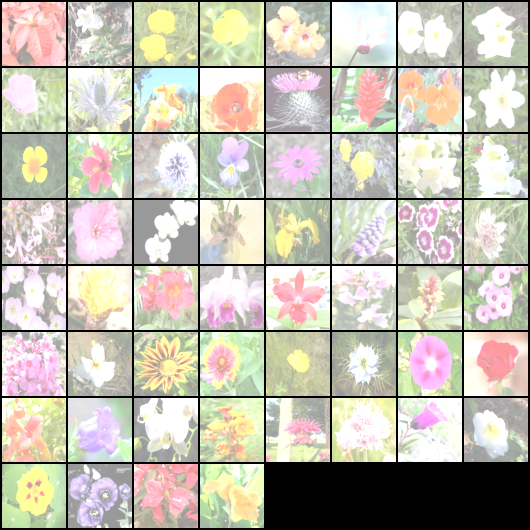

In [44]:
basic_img_flowers = Image(filename='./basic_img_flowers/image_0.png')

display(basic_img_flowers) 

#### Выводим картинку через первые 10 эпох 

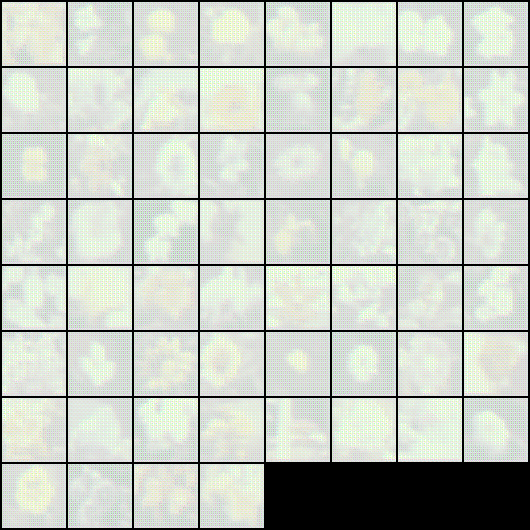

In [45]:
dc_img_flowers = Image(filename='./dc_img_flowers/image_0.png')

display(dc_img_flowers) 

#### Выводим картинку через 20 эпох 

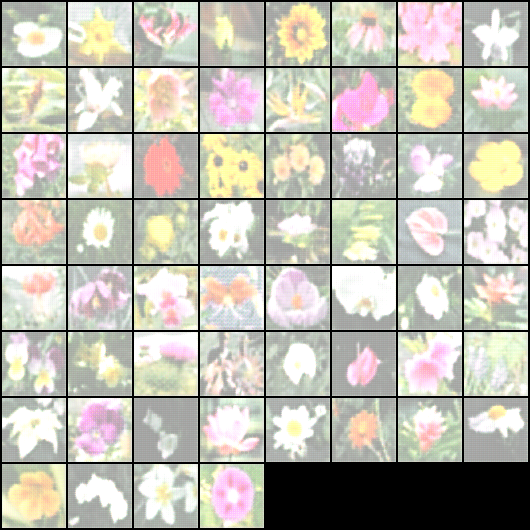

In [46]:
dc_img_flowers = Image(filename='./dc_img_flowers/image_1.png')

display(dc_img_flowers) 

#### Выводим картинку после 30 эпох 

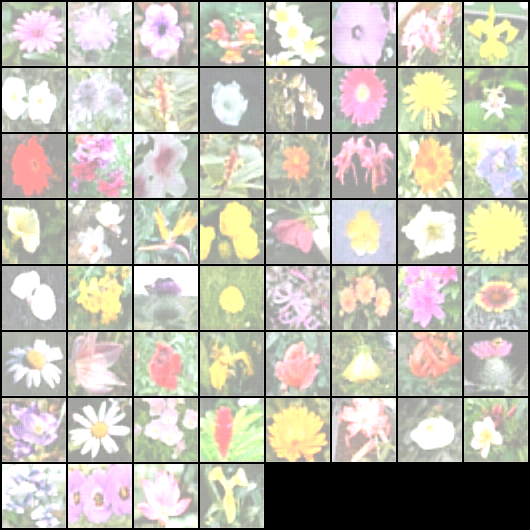

In [47]:
# Выводим картинку после 30 эпох 
dc_img_flowers = Image(filename='./dc_img_flowers/image_2.png')

display(dc_img_flowers) 

#### Вывод промежуточный: 
#### Можем заметить, что наша модель уже через 30 эпох вывела хороший результат, на котором явно можно определить цветочки

<Figure size 1600x1200 with 0 Axes>

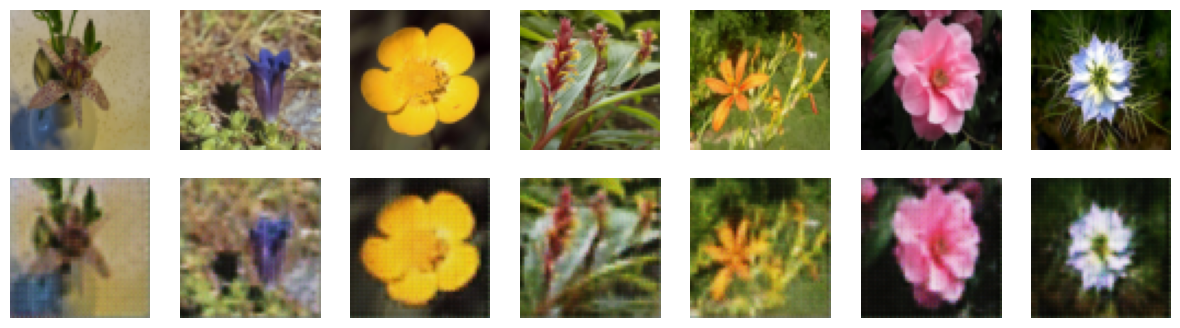

In [48]:
# Рассмотрим наши цветочки повнимательнее:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.to(device)
        recon = model(data)
        break

import matplotlib.pyplot as plt

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

#### Можем увидеть, что искажение все-таки присутствует, так как мы работаем с более серьезными данными, чем в предыдущей реализации

In [97]:
loss_data = []
ssim_data = []
for l, s in sheet:
    loss_data.append(l)
    ssim_data.append(s)

#### Посмотрим теперь на то, как наши метрики качества меняются в зависимости от количества эпох 

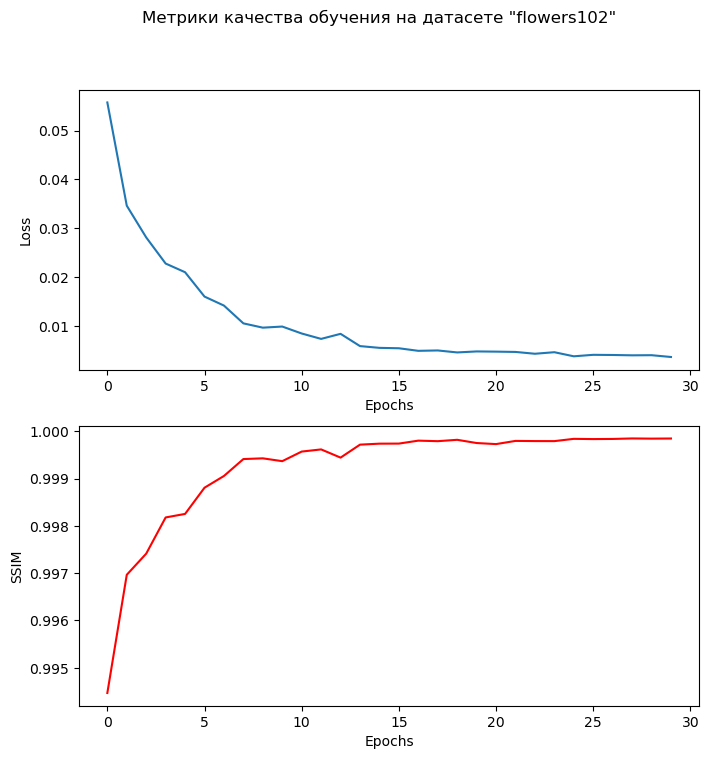

In [113]:
# Посмотрим теперь на то, как наши метрики качества меняются в зависимости от количества эпох 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
fig.suptitle('Метрики качества обучения на датасете "flowers102"')
ax1.plot(loss_data)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax2.plot(ssim_data, color = 'r')
ax2.set_ylabel('SSIM')
ax2.set_xlabel('Epochs')

plt.show()

#### Можем увидеть, что признаков переобучения нет, модель равномерное улучшает свои показатели при увелечении эпох 

#### Теперь реализуем более серьезную CNN модель, которая будет состоять уже  из 5 слоев светки, плюс мы будем дропать половину наших весов в середине энкодера и декодера, чтобы минимизировать шанс переобучения. Работаем с нашей картинкой следующим образом: 
### 64 x 64 -> 32 x 32 -> 16 x 16 -> 8 x 8  -> 4 
###                                              4 x 4 -> 8 x 8 -> 16 x 16 -> 32 x 32 -> 64 x 64

In [47]:
 def get_arch_impoved(f):
        encoder = nn.Sequential(
 
            nn.Conv2d(3, 16, 3, stride=2, padding=1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(),   
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )

        decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
             nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
             nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.Dropout(p=0.5),  
            nn.BatchNorm2d(32), 
            nn.ReLU(),
             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        if f == "encoder":
            return encoder
        elif f == "decoder":
            return decoder
        else:
            print("Incorrect input data, try again")

#### Тут у нас точно такой же класс автоэнкодера только для улучшенной модели 

In [48]:
class Autoencoder_flowers_improved(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = get_arch_impoved("encoder")
        self.decoder = get_arch_impoved("decoder")

    def save_model(self, model):
        torch.save(model.state_dict(), "model_weights_flowers.pth") 

    def load_model(self):
        # загружаем веса нащей модели в файл "model_weights_flowers.pth"
        model = TheModelClass(*args, **kwargs) 
        model.load_state_dict(torch.load("model_weights_flowers.pth"))
        return model

    def forward(self, x):
        # определяем, как наша модель будет работать на выходе и входе 
        #  (подаем данные, пропускаем через энкодер, потом выход из энкодера прогонаем через декодер и возвращаем аутпут)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Создаем объект класса и смотрим, что в модели присутствуют все слои

In [49]:
model_improved = Autoencoder_flowers_improved()
optimizer = torch.optim.Adam(model_improved.parameters(), lr=1e-3, weight_decay=1e-5)

In [50]:
from pytorchtools import EarlyStopping

ImportError: cannot import name 'EarlyStopping' from 'pytorchtools' (C:\Users\te200\anaconda3\envs\pytorch_env\Lib\site-packages\pytorchtools\__init__.py)

In [51]:
model_improved.to(device)

Autoencoder_flowers_improved(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), paddi

#### Обучаем нашу модель и выводим необходимые нам метрики 

In [52]:
sheet = []
num_epochs = 30
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model_improved(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        total_loss += loss.data
        ssim = StructuralSimilarityIndexMeasure(data_range=255)
        ssim_none = ssim(output.to(host), img.to(host))
    sheet.append((loss.item(), ssim_none.item()))
    log.info('epoch [{}/{}], loss:{:.4f}, total_loss:{:.4f}, SSIM:{:.4f}'
            .format(epoch+1, num_epochs, loss.item(), total_loss, ssim_none))
    if epoch % 10 == 0:
        tmp = data[0]
        save_image(to_img_flowers(output), './dc_img_flowers/image_{}.png'.format(epoch//10))
        save_image(to_img_flowers(data[0]), './basic_img_flowers/image_{}.png'.format(epoch//10))

25-Jan-24 16:51 [INFO] Run-Lambda - epoch [1/30], loss:0.0689, total_loss:1.3346, SSIM:0.9922
25-Jan-24 16:51 [INFO] Run-Lambda - epoch [2/30], loss:0.0630, total_loss:1.0592, SSIM:0.9929
25-Jan-24 16:51 [INFO] Run-Lambda - epoch [3/30], loss:0.0458, total_loss:0.8348, SSIM:0.9949
25-Jan-24 16:51 [INFO] Run-Lambda - epoch [4/30], loss:0.0427, total_loss:0.7122, SSIM:0.9954
25-Jan-24 16:52 [INFO] Run-Lambda - epoch [5/30], loss:0.0376, total_loss:0.6314, SSIM:0.9959
25-Jan-24 16:52 [INFO] Run-Lambda - epoch [6/30], loss:0.0324, total_loss:0.5691, SSIM:0.9967
25-Jan-24 16:52 [INFO] Run-Lambda - epoch [7/30], loss:0.0282, total_loss:0.5065, SSIM:0.9973
25-Jan-24 16:52 [INFO] Run-Lambda - epoch [8/30], loss:0.0259, total_loss:0.4587, SSIM:0.9976
25-Jan-24 16:52 [INFO] Run-Lambda - epoch [9/30], loss:0.0244, total_loss:0.4213, SSIM:0.9978
25-Jan-24 16:53 [INFO] Run-Lambda - epoch [10/30], loss:0.0250, total_loss:0.3980, SSIM:0.9977
25-Jan-24 16:53 [INFO] Run-Lambda - epoch [11/30], loss:0.0

#### Можем заметить, что ошибка получилась в 4 раза больше, 
####  чем у нашей обычной модели. Причины: самая ключевая и очевидная - переобучение. 
####  Плюс мы еще сжимаем картинку до 4x4 теряя таким образом, вероятно, часть важных фичей, 
####  в результате чего страдает точность. Веса дропались и это действительно помогало, так как без этого 
####  модель выдавала значительно хуже результат, но тем не менее она еще далека от идеала. Что нужно было 
####  еще добавить: ранную остановку, которая бы контролировала возникновение переобучения, а так же стоило 
####  воспользоваться более совершенной архитектурой: resNet, чтобы при обратном распространении ошибки 
####  мы могли доходить до самого последнего слоя весов по обходным путям через слои

In [53]:
loss_data = []
ssim_data = []
for l, s in sheet:
    loss_data.append(l)
    ssim_data.append(s)

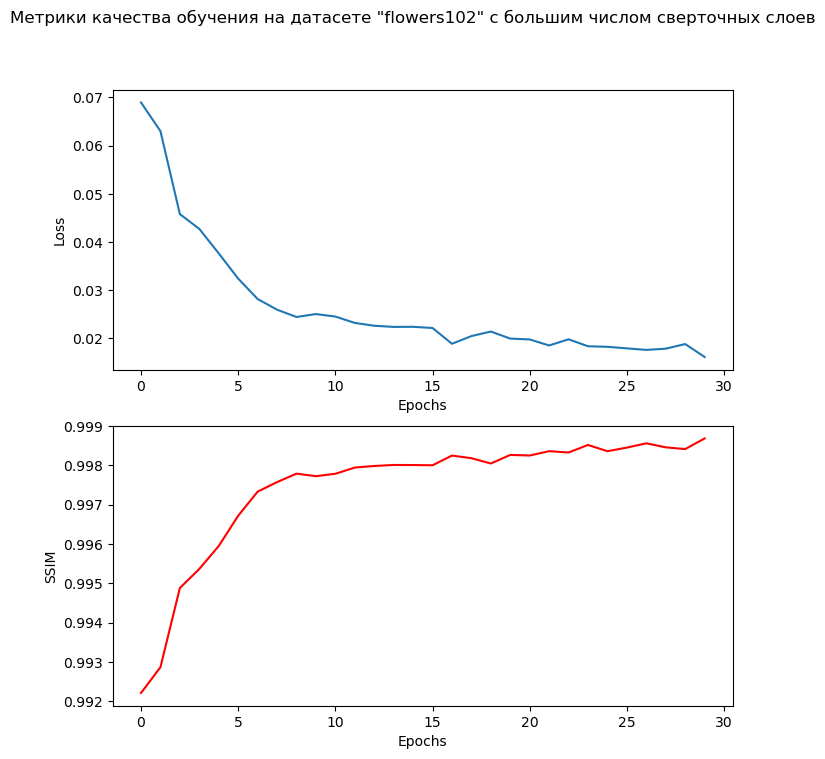

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
fig.suptitle('Метрики качества обучения на датасете "flowers102" с большим числом сверточных слоев')
ax1.plot(loss_data)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax2.plot(ssim_data, color = 'r')
ax2.set_ylabel('SSIM')
ax2.set_xlabel('Epochs')

plt.show()

#### Как раз на графиках мы можем заиетитть что после примерно 15 эпох наша модель стала переобучаться, то есть ошибка и SSIM в лучшем случае не изменялись, а в хучшем показывали еще более плохие результаты.
#### Итог: в ходе данного тз были реализованы 3 разных архитектуры, 
#### одна из которых применялась для MNIST изображений, а 2 других для flowers102. 
#### Мы посмотрели на качество моделий, восстановили зашумленное изображение, 
#### посмотрели на поведение метрик и просто получили большое количество опыта и информации о автоэнкодерах, 
#### их назначении и принципе работы!